In [264]:
from web3 import Web3
import keyring
from tqdm import tqdm, trange
import pandas as pd
from etherscan import Etherscan
import binascii

from eth_abi import decode


import matplotlib.pyplot as plt

In [221]:
etherscan_api_key = keyring.get_password("system", "ETHERSCAN_API_KEY")
infura_project_id = keyring.get_password("system", "INFURA_PROJECT_ID")
the_graph_api_key = keyring.get_password("system", "THE_GRAPH_API_KEY")

In [116]:
w3 = Web3(Web3.HTTPProvider(f"https://mainnet.infura.io/v3/{infura_project_id}"))

eth = Etherscan(etherscan_api_key) # key in quotation marks

In [67]:
latest_block = w3.eth.get_block('latest')

len(latest_block['transactions'])

256

In [71]:
t_hashes = latest_block['transactions']

transactions = [w3.eth.get_transaction(h) for h in tqdm(t_hashes)]

transactions[0]

100%|██████████| 256/256 [00:07<00:00, 34.72it/s]


AttributeDict({'accessList': [AttributeDict({'address': '0x41a3cdbad6bef840460e3ef7abf66f614ae0698f',
   'storageKeys': ['0x000000000000000000000000000000000000000000000000000000000000000c',
    '0x0000000000000000000000000000000000000000000000000000000000000008',
    '0x0000000000000000000000000000000000000000000000000000000000000006',
    '0x0000000000000000000000000000000000000000000000000000000000000007',
    '0x0000000000000000000000000000000000000000000000000000000000000009',
    '0x000000000000000000000000000000000000000000000000000000000000000a']}),
  AttributeDict({'address': '0xa9929db24e9837f622f94b82f2abe78aa971288f',
   'storageKeys': ['0xa551e7b29399e2ed03f4b496016674fff6aef40be78bbfa6eb7876b6240bc705',
    '0xb39e9ba92c3c47c76d4f70e3bc9c3270ab78d2592718d377c8f5433a34d3470a']}),
  AttributeDict({'address': '0x1428c73e010eb4c230564f356d9f4dfbf1e1f757',
   'storageKeys': ['0x0000000000000000000000000000000000000000000000000000000000000008',
    '0x00000000000000000000000000

In [120]:
# usdceth005 = '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640'
# usdceth005 = '0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad'
uniswap_router = '0xE592427A0AEce92De3Edee1F18E0157C05861564'

UNISWAP_V3_FACTORY_ADDRESS = "0x1F98431c8aD98523631AE4a59f267346ea31F984"  # Uniswap V3 Factory Address


In [75]:
# Get the latest block number
latest_block = w3.eth.block_number

# Get the 100 latest blocks
blocks = [w3.eth.get_block(i, full_transactions=True) for i in trange(latest_block - 100, latest_block)]

len(blocks)

100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


100

In [76]:
# Collect all transactions from the last 100 blocks
transactions = []
for block in blocks:
    transactions.extend(block['transactions'])

len(transactions)

16859

In [77]:
# Filter transactions to only include Uniswap V3 transactions on the USDC/ETH 0.05% pool
uniswap_transactions = []

for tx in transactions:
    if tx['to'] and tx['to'].lower() == uniswap_router:
        uniswap_transactions.append(tx)

len(uniswap_transactions)

14

In [78]:
import requests
import json

def get_abi(contract_address):
    url = f"https://api.etherscan.io/api?module=contract&action=getabi&address={contract_address}&apikey={etherscan_api_key})"
    response = requests.get(url)
    return response.json()['result']

router_abi = get_abi(uniswap_router)

router_abi

'[{"inputs":[{"internalType":"address","name":"_factory","type":"address"},{"internalType":"address","name":"_WETH9","type":"address"}],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[],"name":"WETH9","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"components":[{"internalType":"bytes","name":"path","type":"bytes"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint256","name":"amountIn","type":"uint256"},{"internalType":"uint256","name":"amountOutMinimum","type":"uint256"}],"internalType":"struct ISwapRouter.ExactInputParams","name":"params","type":"tuple"}],"name":"exactInput","outputs":[{"internalType":"uint256","name":"amountOut","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[{"components":[{"internalType":"address","name":"tokenIn","type":"address"},{"internalType":"add

### Inspect a single Uniswap V3 transaction

In [83]:
contract = w3.eth.contract(address=uniswap_router, abi=router_abi)

# Now we can decode the input data
input_data = uniswap_transactions[1]['input']

# Find the matching function in the contract
# function = contract.get_function_by_name("exactInput")

function, decoded_params = contract.decode_function_input(input_data)

functions = []
# Loop through the data parameters and decode each one separately
for data in decoded_params['data']:
    try:
        # Try to decode the function call
        inner_function, inner_params = contract.decode_function_input(data)
        functions.append((inner_function, inner_params))
        print(inner_function, inner_params)
    except ValueError:
        # If it fails to decode, just print the raw data
        print(data)

<Function exactInputSingle((address,address,uint24,address,uint256,uint256,uint256,uint160))> {'params': {'tokenIn': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2', 'tokenOut': '0xe8A3Bf796cA5a13283ec6B1c5b645B91D7CfEf5D', 'fee': 3000, 'recipient': '0xf10CaB8A78B35876338Af81C7caf8eBD6d5DfD9B', 'deadline': 1686153234, 'amountIn': 500000000000000000, 'amountOutMinimum': 2663149738936948323911, 'sqrtPriceLimitX96': 0}}


In [86]:
functions[0][0].fn_name

'exactInputSingle'

In [87]:
erc20_abi = """
[
    {
        "constant":true,
        "inputs":[],
        "name":"name",
        "outputs":[{"name":"","type":"string"}],
        "payable":false,
        "stateMutability":"view",
        "type":"function"
    },
    {
        "constant":true,
        "inputs":[],
        "name":"symbol",
        "outputs":[{"name":"","type":"string"}],
        "payable":false,
        "stateMutability":"view",
        "type":"function"
    },
    {
        "constant":true,
        "inputs":[],
        "name":"decimals",
        "outputs":[{"name":"","type":"uint8"}],
        "payable":false,
        "stateMutability":"view",
        "type":"function"
    }
]
"""

In [143]:
address2data = {}

def get_token_details(token_address):

    if token_address in address2data:
        return address2data[token_address]
    
    token_contract = w3.eth.contract(address=token_address, abi=erc20_abi)
    name = token_contract.functions.name().call()
    symbol = token_contract.functions.symbol().call()
    decimals = token_contract.functions.decimals().call()

    address2data[token_address] = {"name": name, "symbol": symbol, "decimals": decimals}

    return address2data[token_address]


In [89]:
get_token_details('0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')

{'name': 'Wrapped Ether', 'symbol': 'WETH', 'decimals': 18}

### Get the transaction data from all the Uniswap V3 transactions in a DataFrame

In [144]:
tx_data = []
errors = []

contract = w3.eth.contract(address=uniswap_router, abi=router_abi)

for tx in tqdm(uniswap_transactions):
    input_data = tx['input']
    function, decoded_params = contract.decode_function_input(input_data)

    if 'params' in decoded_params:
        tx_data.append({'tx_hash': tx['hash'], 'function': function.fn_name, **decoded_params['params']})
        continue

    for data in decoded_params['data']:
        try:
            # Try to decode the function call to exactInputSingle and exactOutputSingle
            # Can look into tackling exactOutput and exactInput later
            inner_function, inner_params = contract.decode_function_input(data)

            # If function is not exactInputSingle or exactOutputSingle, skip it
            if inner_function.fn_name not in ['exactInputSingle', 'exactOutputSingle', 'exactInput', 'exactOutput']:
                continue

            # Otherwise, add the decoded parameters to the data list
            tx_data.append({
                'tx_hash': tx['hash'],
                'function': inner_function.fn_name,
                **inner_params['params'],
            })

        except ValueError:
            # If it fails to decode, add the raw data to the errors list
            errors.append(data)


# Convert the data list to a DataFrame
df = pd.DataFrame(tx_data)

# Convert the deadline column to a datetime
df['deadline'] = pd.to_datetime(df['deadline'], unit='s')

# Convert tokenIn and tokenOut to token symbols
df['tokenIn'] = df['tokenIn'].apply(lambda x: get_token_details(x)['symbol'])
df['tokenOut'] = df['tokenOut'].apply(lambda x: get_token_details(x)['symbol'])

df


100%|██████████| 14/14 [00:00<00:00, 585.00it/s]

,tx_hash,function,tokenIn,tokenOut,fee,recipient,deadline,amountOut,amountInMaximum,sqrtPriceLimitX96,amountIn,amountOutMinimum
0,b'\xeb.\x154s\x1c\x01\xa9\xb4`\xb7\x93:\x02\xd...,exactOutputSingle,HABIBI,WETH,10000,0x0000000000000000000000000000000000000000,2023-06-07 15:52:23,7.000000e+17,153931205182387586439169985,0,NaN,NaN
1,b'\x06\xad\xc5\x92\x00\xdc\xc93Z{|*\xf5\x13\x8...,exactInputSingle,WETH,ZVT,3000,0xf10CaB8A78B35876338Af81C7caf8eBD6d5DfD9B,2023-06-07 15:53:54,NaN,NaN,0,500000000000000000,2663149738936948323911
2,b'O\xcc\xc3u\x02\x13m~\x0b\xa2\x96n\xf1A\x96\x...,exactInputSingle,XDEFI,WETH,10000,0x0000000000000000000000000000000000000000,2023-06-07 15:35:07,NaN,NaN,0,5000000000000000000000,236801534560641568
3,b'$E\xdd\xeb\r\x96U\x87qr\x05.\x82p\xc1\x85\x1...,exactInputSingle,ferc,WETH,3000,0x0000000000000000000000000000000000000000,2023-06-07 15:57:59,NaN,NaN,0,600000000000000000000,221836201320212161
4,b'Q\x111y\xbf\xb2\x1eM\xf8\x16$\x8c(}R\xc5\xfd...,exactInputSingle,WETH,HABIBI,10000,0x72A7c15a706C79c09015AF607cbE564e560c1e5E,2023-06-07 15:39:10,NaN,NaN,0,600000000000000000,0
5,"b'\xf0b\xd7)TX^x\xee:\xe4,\xbf\xb9\xd3)\xf56\x...",exactInputSingle,OX,WETH,10000,0x0000000000000000000000000000000000000000,2023-06-07 15:40:27,NaN,NaN,0,364936236755224139547915,0
6,"b""\xb1\xa0\x02v|\x06-\x90i\xe7\xa1\xa9\xfd'\x0...",exactInputSingle,HABIBI,WETH,10000,0x0000000000000000000000000000000000000000,2023-06-07 15:35:23,NaN,NaN,0,160471694898943830624582600,739698954910684369
7,b'g\x16\xea\xca\xb0\x0c[v]\x9e\xe8/6\x81\xd7\x...,exactInputSingle,WETH,USDC,500,0x86dbd250f98E0ACF1414A399133E6288B9017438,2023-06-07 16:01:47,NaN,NaN,0,6000000000000000000,10979772322
8,b'}C\x8f}\x8e\x10\x06\xb1\x1e\xf0\xb1*s\xb6\xe...,exactInputSingle,WETH,XEN,10000,0x5D51D35e63bC2286d991e68e0d135D3babe9c01a,2023-06-07 15:39:40,NaN,NaN,0,2000000000000000000,2117981075200000000000000000
9,"b""K\xea\xfd\xd40\xca\x1f,!=\x95\xa3\x8cT\x7f\x...",exactInputSingle,HABIBI,WETH,10000,0x0000000000000000000000000000000000000000,2023-06-07 16:07:59,NaN,NaN,0,21376919940734241339281435,91034569817531423


### Get the realized price and volume from the Uniswap swap event logs

In [145]:
pool_abi = eth.get_contract_abi('0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8')
factory_abi = eth.get_contract_abi(UNISWAP_V3_FACTORY_ADDRESS)

factory = w3.eth.contract(address=Web3.to_checksum_address(UNISWAP_V3_FACTORY_ADDRESS), abi=factory_abi)

In [146]:
pool_contracts = {}

In [218]:
tx_data = []
errors = []

for tx in tqdm(uniswap_transactions):
    input_data = tx['input']
    function, decoded_params = contract.decode_function_input(input_data)

    if 'params' in decoded_params:
        decoded_params['data'] = [decoded_params['params']]

    for data in decoded_params['data']:

        try:
            # Try to decode the function call to exactInputSingle and exactOutputSingle
            # Can look into tackling exactOutput and exactInput later
            if isinstance(data, dict):
                inner_function = function
                inner_params = {'params': data}
            else:
                inner_function, inner_params = contract.decode_function_input(data)

            # If function is not exactInputSingle or exactOutputSingle, skip it
            if inner_function.fn_name not in ['exactInputSingle', 'exactOutputSingle']:
                continue

            # Create the pair string
            pair = inner_params['params']['tokenIn'] + '_' + inner_params['params']['tokenOut']

            # If the pair contract hasn't been loaded yet, load it
            if pair not in pool_contracts:
                pool_address = factory.functions.getPool(inner_params['params']['tokenIn'], inner_params['params']['tokenOut'], inner_params['params']['fee']).call()
                pool_contracts[pair] = w3.eth.contract(address=pool_address, abi=pool_abi)
            
            # Get the pair contract
            pool_contract = pool_contracts[pair]
            
            # Fetch the events
            swap_events = pool_contract.events.Swap.get_logs(fromBlock=tx['blockNumber'], toBlock=tx['blockNumber'])

            # Find the event for the specific transaction
            event = next((event for event in swap_events if event['transactionHash'] == tx['hash']), None)
            
            if event is None:
                continue

            # Get out token in and out addresses
            token_in_addr = inner_params['params'].pop('tokenIn')
            token_out_addr = inner_params['params'].pop('tokenOut')

            token_in_details = get_token_details(token_in_addr)
            token_out_details = get_token_details(token_out_addr)

            amount_in = event['args']['amount0'] if event['args']['amount0'] > 0 else event['args']['amount1']
            amount_out = -(event['args']['amount1'] if event['args']['amount0'] > 0 else event['args']['amount0'])

            amount_in /= 10 ** token_in_details['decimals']
            amount_out /= 10 ** token_out_details['decimals']

            tx_data.append({
                'tx_hash': '0x' + binascii.hexlify(tx['hash']).decode(),
                'function': inner_function.fn_name,
                'status': w3.eth.get_transaction_receipt(tx['hash'])['status'],
                'tokenIn': token_in_details['symbol'],
                'tokenOut': token_out_details['symbol'],
                'amountIn': amount_in,
                'amountOut': amount_out,
                'tokenInAddr': token_in_addr,
                'tokenOutAddr': token_out_addr,
                'from': tx['from'],
                'fee': inner_params['params']['fee'],
                'recipient': inner_params['params']['recipient'],
                'deadline': inner_params['params']['deadline'],
                'sqrtPriceLimitX96': inner_params['params']['sqrtPriceLimitX96'],
                'sqrtPriceX96': event['args']['sqrtPriceX96'],
                'tick': event['args']['tick'],
                'liquidity': event['args']['liquidity'],
            })

        except ValueError:
            # If it fails to decode, add the raw data to the errors list
            errors.append(data)


100%|██████████| 14/14 [00:00<00:00, 15.56it/s]


In [219]:
# Make the DataFrame
df = pd.DataFrame(tx_data)

# Convert the deadline column to a datetime
df['deadline'] = pd.to_datetime(df['deadline'], unit='s')

# Convert amountIn and amountOut to floats
df['amountIn'] = df['amountIn'].astype(float)
df['amountOut'] = df['amountOut'].astype(float)


print(df.tx_hash.to_list())

df

['0xeb2e1534731c01a9b460b7933a02d2c062d9d6a6a05c43ef65b34f868e590c6d', '0x06adc59200dcc9335a7b7c2af51389bfa6dd227e0dfbdceccf4a61ab3765d55c', '0x4fccc37502136d7e0ba2966ef14196fa725e69db64f2e469b25cb1a8410414f9', '0x2445ddeb0d9655877172052e8270c185141c7f81b2b3b060b67e9f20c5911b19', '0x51113179bfb21e4df816248c287d52c5fdbe805212e3575df7c067615a749f44', '0xf062d72954585e78ee3ae42cbfb9d329f53607a278b13aed24d88eb5c3c6d51f', '0xb1a002767c062d9069e7a1a9fd270f46634c48dba9d6f694e8ce3c07804e6ffc', '0x6716eacab00c5b765d9ee82f3681d77f1ca342e0a817a95b4a28de56c156d802', '0x7d438f7d8e1006b11ef0b12a73b6e1757c116756058f88bed58b9f9e18d7cab3', '0x4beafdd430ca1f2c213d95a38c547fe84097302745642565d8ebfc507017a704', '0x3a56318db97733be20db708ffad764fd8fad980a2e51781cbe2a5f97bc2267fb', '0x728daa1e969f81b96050ed265cd3b31c1e4304f3333adb55c10c10a88bdead65', '0xdff7c3c1f1c605f614f9aaf02db478687e9044def85efb4879b565f9e7ad58c4']


,tx_hash,function,status,tokenIn,tokenOut,amountIn,amountOut,tokenInAddr,tokenOutAddr,from,fee,recipient,deadline,sqrtPriceLimitX96,sqrtPriceX96,tick,liquidity
0,0xeb2e1534731c01a9b460b7933a02d2c062d9d6a6a05c...,exactOutputSingle,1,HABIBI,WETH,1.487252e+08,7.000000e-01,0x8526Be2379E853d5Cf02f9823BB9690e1a6Ff9e2,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x0F4Fc2d34d88e21d3a7c3B9A80af1F013B7b6b3a,10000,0x0000000000000000000000000000000000000000,2023-06-07 15:52:23,0,5458943525156039383757804,-191667,7109211605415841545396517
1,0x06adc59200dcc9335a7b7c2af51389bfa6dd227e0dfb...,exactInputSingle,1,WETH,ZVT,5.000000e-01,2.676465e+03,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0xe8A3Bf796cA5a13283ec6B1c5b645B91D7CfEf5D,0xf10CaB8A78B35876338Af81C7caf8eBD6d5DfD9B,3000,0xf10CaB8A78B35876338Af81C7caf8eBD6d5DfD9B,2023-06-07 15:53:54,0,5805301156298224437031552634223,85888,2581875815911822328199964
2,0x4fccc37502136d7e0ba2966ef14196fa725e69db64f2...,exactInputSingle,1,XDEFI,WETH,5.000000e+03,2.391935e-01,0x72B886d09C117654aB7dA13A14d603001dE0B777,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0xdcB7a9fb0640005ca7034427552b90c9B13cc2a0,10000,0x0000000000000000000000000000000000000000,2023-06-07 15:35:07,0,550420116527957784144467129,-99394,29034567679359434833314
3,0x2445ddeb0d9655877172052e8270c185141c7f81b2b3...,exactInputSingle,1,ferc,WETH,6.000000e+02,2.229454e-01,0x2eCBa91da63C29EA80Fbe7b52632CA2d1F8e5Be0,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0xBC0D2f3C9C958281774fbDBeF45d4E6413f14a92,3000,0x0000000000000000000000000000000000000000,2023-06-07 15:57:59,0,1509732439498121700351206854,-79212,443387285161389283748
4,0x51113179bfb21e4df816248c287d52c5fdbe805212e3...,exactInputSingle,1,WETH,HABIBI,6.000000e-01,1.249177e+08,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x8526Be2379E853d5Cf02f9823BB9690e1a6Ff9e2,0x72A7c15a706C79c09015AF607cbE564e560c1e5E,10000,0x72A7c15a706C79c09015AF607cbE564e560c1e5E,2023-06-07 15:39:10,0,5466682748216534188613395,-191638,7109211605415841545396517
5,0xf062d72954585e78ee3ae42cbfb9d329f53607a278b1...,exactInputSingle,1,OX,WETH,3.649362e+05,3.993395e+00,0x78a0A62Fba6Fb21A83FE8a3433d44C73a4017A6f,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x3b65AA2c597EB47135F1A2C85A98bd3C7b957035,10000,0x0000000000000000000000000000000000000000,2023-06-07 15:40:27,0,263183827320781153387123568,-114151,713739538353044437209656
6,0xb1a002767c062d9069e7a1a9fd270f46634c48dba9d6...,exactInputSingle,1,HABIBI,WETH,1.604717e+08,7.544929e-01,0x8526Be2379E853d5Cf02f9823BB9690e1a6Ff9e2,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x6b76392cB3cdC40AFF6C586ce9ed347AeBfb38B1,10000,0x0000000000000000000000000000000000000000,2023-06-07 15:35:23,0,5455768658507809229116340,-191678,7109211605415841545396517
7,0x6716eacab00c5b765d9ee82f3681d77f1ca342e0a817...,exactInputSingle,1,WETH,USDC,6.000000e+00,1.109338e+04,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,0x86dbd250f98E0ACF1414A399133E6288B9017438,500,0x86dbd250f98E0ACF1414A399133E6288B9017438,2023-06-07 16:01:47,0,1842113851358722721662252643365746,201091,29624806703546607635
8,0x7d438f7d8e1006b11ef0b12a73b6e1757c116756058f...,exactInputSingle,1,WETH,XEN,2.000000e+00,2.128624e+09,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x06450dEe7FD2Fb8E39061434BAbCFC05599a6Fb8,0x7340C899B795D8104170C822dC11463Fc3F6a4d2,10000,0x5D51D35e63bC2286d991e68e0d135D3babe9c01a,2023-06-07 15:39:40,0,2419454556721811445622109,-207942,25410277202465765921336295
9,0x4beafdd430ca1f2c213d95a38c547fe8409730274564...,exactInputSingle,1,HABIBI,WETH,2.137692e+07,9.360602e-02,0x8526Be2379E853d5Cf02f9823BB9690e1a6Ff9e2,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0x1e99E74E95486A83dEba235C143B38b2a9Ef0713,10000,0x0000000000000000000000000000000000000000,2023-06-07 16:07:59,0,5268637632041762726749796,-192376,7109211605415841545396517


### Query the subgraph

In [230]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
import json

# Define the API endpoint
transport = RequestsHTTPTransport(url=f'https://gateway.thegraph.com/api/{the_graph_api_key}/subgraphs/id/ELUcwgpm14LKPLrBRuVvPvNKHQ9HvwmtKgKSH6123cr7')

client = Client(transport=transport, fetch_schema_from_transport=True)

# Define the base query
query = gql('''
  query GetLiquidityPool($id: ID!, $blockNumber: Int!) {
    liquidityPool(id: $id, block: { number: $blockNumber }) {
      id
      inputTokens {symbol}
      protocol {name}
      name
      fees {feePercentage feeType}
      totalValueLockedUSD
      inputTokenBalances
      inputTokenWeights
      withdraws {id inputTokenAmounts amountUSD}
      deposits {id inputTokenAmounts amountUSD}
      swaps {id blockNumber tokenIn {symbol} amountIn tokenOut {symbol} amountOut}

    }
  }
''')

# Define the pool ID and the range of blocks you're interested in
pool_id = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
end_block = 17444720

block_data = []

# Iterate over the blocks
for block_number in trange(end_block - 10, end_block + 1):
    variables = {"id": pool_id, "blockNumber": block_number}
    result = client.execute(query, variable_values=variables)
    block_data.append(result['liquidityPool'])

len(block_data)


100%|██████████| 11/11 [01:17<00:00,  7.03s/it]


11

In [236]:
# replace these with the actual contract address and ABI
uniswap_v3_pool_address = '0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640'
uniswap_v3_pool_abi = """[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount","type":"uint128"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"Burn","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":false,"internalType":"address","name":"recipient","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount0","type":"uint128"},{"indexed":false,"internalType":"uint128","name":"amount1","type":"uint128"}],"name":"Collect","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint128","name":"amount0","type":"uint128"},{"indexed":false,"internalType":"uint128","name":"amount1","type":"uint128"}],"name":"CollectProtocol","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"paid0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"paid1","type":"uint256"}],"name":"Flash","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint16","name":"observationCardinalityNextOld","type":"uint16"},{"indexed":false,"internalType":"uint16","name":"observationCardinalityNextNew","type":"uint16"}],"name":"IncreaseObservationCardinalityNext","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"indexed":false,"internalType":"int24","name":"tick","type":"int24"}],"name":"Initialize","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount","type":"uint128"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"Mint","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint8","name":"feeProtocol0Old","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol1Old","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol0New","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol1New","type":"uint8"}],"name":"SetFeeProtocol","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"int256","name":"amount0","type":"int256"},{"indexed":false,"internalType":"int256","name":"amount1","type":"int256"},{"indexed":false,"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"indexed":false,"internalType":"uint128","name":"liquidity","type":"uint128"},{"indexed":false,"internalType":"int24","name":"tick","type":"int24"}],"name":"Swap","type":"event"},{"inputs":[{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount","type":"uint128"}],"name":"burn","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount0Requested","type":"uint128"},{"internalType":"uint128","name":"amount1Requested","type":"uint128"}],"name":"collect","outputs":[{"internalType":"uint128","name":"amount0","type":"uint128"},{"internalType":"uint128","name":"amount1","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint128","name":"amount0Requested","type":"uint128"},{"internalType":"uint128","name":"amount1Requested","type":"uint128"}],"name":"collectProtocol","outputs":[{"internalType":"uint128","name":"amount0","type":"uint128"},{"internalType":"uint128","name":"amount1","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"factory","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"fee","outputs":[{"internalType":"uint24","name":"","type":"uint24"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeGrowthGlobal0X128","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeGrowthGlobal1X128","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"flash","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint16","name":"observationCardinalityNext","type":"uint16"}],"name":"increaseObservationCardinalityNext","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"}],"name":"initialize","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"liquidity","outputs":[{"internalType":"uint128","name":"","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"maxLiquidityPerTick","outputs":[{"internalType":"uint128","name":"","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount","type":"uint128"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"mint","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"","type":"uint256"}],"name":"observations","outputs":[{"internalType":"uint32","name":"blockTimestamp","type":"uint32"},{"internalType":"int56","name":"tickCumulative","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityCumulativeX128","type":"uint160"},{"internalType":"bool","name":"initialized","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32[]","name":"secondsAgos","type":"uint32[]"}],"name":"observe","outputs":[{"internalType":"int56[]","name":"tickCumulatives","type":"int56[]"},{"internalType":"uint160[]","name":"secondsPerLiquidityCumulativeX128s","type":"uint160[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"name":"positions","outputs":[{"internalType":"uint128","name":"liquidity","type":"uint128"},{"internalType":"uint256","name":"feeGrowthInside0LastX128","type":"uint256"},{"internalType":"uint256","name":"feeGrowthInside1LastX128","type":"uint256"},{"internalType":"uint128","name":"tokensOwed0","type":"uint128"},{"internalType":"uint128","name":"tokensOwed1","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"protocolFees","outputs":[{"internalType":"uint128","name":"token0","type":"uint128"},{"internalType":"uint128","name":"token1","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint8","name":"feeProtocol0","type":"uint8"},{"internalType":"uint8","name":"feeProtocol1","type":"uint8"}],"name":"setFeeProtocol","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"slot0","outputs":[{"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"internalType":"int24","name":"tick","type":"int24"},{"internalType":"uint16","name":"observationIndex","type":"uint16"},{"internalType":"uint16","name":"observationCardinality","type":"uint16"},{"internalType":"uint16","name":"observationCardinalityNext","type":"uint16"},{"internalType":"uint8","name":"feeProtocol","type":"uint8"},{"internalType":"bool","name":"unlocked","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"}],"name":"snapshotCumulativesInside","outputs":[{"internalType":"int56","name":"tickCumulativeInside","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityInsideX128","type":"uint160"},{"internalType":"uint32","name":"secondsInside","type":"uint32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"bool","name":"zeroForOne","type":"bool"},{"internalType":"int256","name":"amountSpecified","type":"int256"},{"internalType":"uint160","name":"sqrtPriceLimitX96","type":"uint160"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"swap","outputs":[{"internalType":"int256","name":"amount0","type":"int256"},{"internalType":"int256","name":"amount1","type":"int256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"int16","name":"","type":"int16"}],"name":"tickBitmap","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"tickSpacing","outputs":[{"internalType":"int24","name":"","type":"int24"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"int24","name":"","type":"int24"}],"name":"ticks","outputs":[{"internalType":"uint128","name":"liquidityGross","type":"uint128"},{"internalType":"int128","name":"liquidityNet","type":"int128"},{"internalType":"uint256","name":"feeGrowthOutside0X128","type":"uint256"},{"internalType":"uint256","name":"feeGrowthOutside1X128","type":"uint256"},{"internalType":"int56","name":"tickCumulativeOutside","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityOutsideX128","type":"uint160"},{"internalType":"uint32","name":"secondsOutside","type":"uint32"},{"internalType":"bool","name":"initialized","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"token0","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"token1","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"}]"""

uniswap_v3_pool = w3.eth.contract(address=uniswap_v3_pool_address, abi=uniswap_v3_pool_abi)

In [255]:
# replace with the actual method names and arguments (if any)
end_block = 17445391

blockdata = []

for block_number in trange(end_block - 10000, end_block + 1):
    liquidity = uniswap_v3_pool.functions.liquidity().call(block_identifier=block_number)
    sqrtPrice = uniswap_v3_pool.functions.slot0().call(block_identifier=block_number)[0]

    blockdata.append({"block_number": block_number, "liquidity": liquidity, "sqrtPrice": sqrtPrice})

df = pd.DataFrame(blockdata)

100%|██████████| 10001/10001 [22:33<00:00,  7.39it/s] 


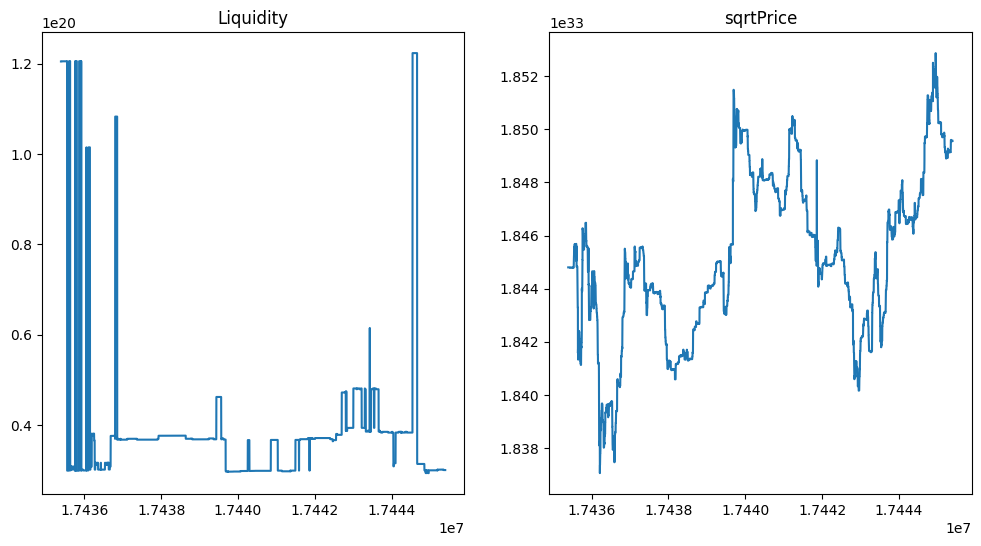

In [258]:
df.liquidity = df.liquidity.astype(float)
df.sqrtPrice = df.sqrtPrice.astype(float)

# Plot both series side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(df.block_number, df.liquidity)
ax1.set_title("Liquidity")
ax2.plot(df.block_number, df.sqrtPrice)
ax2.set_title("sqrtPrice")
plt.show()

In [297]:
# replace these with the actual event signatures
SWAP_EVENT_SIG = w3.keccak(text="Swap(address,address,int256,int256,uint160,uint128,int24)").hex()
MINT_EVENT_SIG = w3.keccak(text="Mint(address,address,int24,int24,uint128,uint256,uint256)").hex()
BURN_EVENT_SIG = w3.keccak(text="Burn(address,int24,int24,uint128,uint256,uint256)").hex()


# get swap events
swap_filter = {
    'fromBlock': end_block - 1000,
    'toBlock': end_block,
    'address': uniswap_v3_pool_address,
    'topics': [SWAP_EVENT_SIG],
}
swap_events = w3.eth.get_logs(swap_filter)

# get mint events (deposits)
mint_filter = {
    'fromBlock': end_block - 1000,
    'toBlock': end_block,
    'address': uniswap_v3_pool_address,
    'topics': [MINT_EVENT_SIG],
}
mint_events = w3.eth.get_logs(mint_filter)

# get burn events (withdrawals)
burn_filter = {
    'fromBlock': end_block - 1000,
    'toBlock': end_block,
    'address': uniswap_v3_pool_address,
    'topics': [BURN_EVENT_SIG],
}
burn_events = w3.eth.get_logs(burn_filter)

len(swap_events), len(mint_events), len(burn_events)

(573, 14, 14)

In [298]:
# let's assume we're working with a Swap event, and swap_events is the array of Swap events we got earlier
for event in sorted(swap_events, key=lambda x: (x['blockNumber'], x['transactionIndex'], x['logIndex'])):
    data = event['data']
    block_number = event['blockNumber']
    transaction_index = event['transactionIndex']
    log_index = event['logIndex']
    hash = event['transactionHash'].hex()

    # the Swap event has four non-indexed arguments: amount0, amount1, sqrtPriceX96, and liquidity
    # all of them are uint256, so we can decode them like this
    types = ['int256', 'int256', 'uint160', 'uint128', 'int24']
    names = ['amount0', 'amount1', 'sqrtPriceX96', 'liquidity', 'tick']
    decoded_data = decode(types, data)
    print(f'Decoded swap {hash}: {dict(zip(names, decoded_data))}, block number: {block_number}, transaction index: {transaction_index}, log index: {log_index}')

# let's assume we're working with a Mint event, and mint_events is the array of Mint events we got earlier
for event in sorted(mint_events, key=lambda x: (x['blockNumber'], x['transactionIndex'], x['logIndex'])):
    data = event['data']
    block_number = event['blockNumber']
    transaction_index = event['transactionIndex']
    log_index = event['logIndex']
    hash = event['transactionHash'].hex()

    # the Mint event has four non-indexed arguments: amount0, amount1, sqrtPriceX96, and liquidity
    # all of them are uint256, so we can decode them like this
    types = ['address', 'uint128', 'uint256', 'uint256']  # sender, amount, amount0, amount1
    names = ['sender', 'amount', 'amount0', 'amount1']
    decoded_data = decode(types, data)
    print(f'Decoded mint {hash}: {dict(zip(names, decoded_data))}, block number: {block_number}, transaction index: {transaction_index}, log index: {log_index}')

# let's assume we're working with a Burn event, and burn_events is the array of Burn events we got earlier
for event in sorted(burn_events, key=lambda x: (x['blockNumber'], x['transactionIndex'], x['logIndex'])):
    data = event['data']
    block_number = event['blockNumber']
    transaction_index = event['transactionIndex']
    log_index = event['logIndex']
    hash = event['transactionHash'].hex()

    # the Burn event has four non-indexed arguments: amount0, amount1, sqrtPriceX96, and liquidity
    # all of them are uint256, so we can decode them like this
    types = ['uint128', 'uint256', 'uint256']  # amount, amount0, amount1
    names = ['amount', 'amount0', 'amount1']
    decoded_data = decode(types, data)
    print(f'Decoded burn {hash}: {dict(zip(names, decoded_data))}, block number: {block_number}, transaction index: {transaction_index}, log index: {log_index}')

Decoded swap 0xc2e45e90b16de7289380419fe43ebaf8e893b1da6a0014ca73eb765ae6133015: {'amount0': -73423381609, 'amount1': 39906760544216865968, 'sqrtPriceX96': 1846659061072910237204567555074458, 'liquidity': 38341279712827580700, 'tick': 201141}, block number: 17444391, transaction index: 10, log index: 77
Decoded swap 0x06b18786a9dd6c7d163c53be3739f704656a4f07f0e685d7821780d940c4dafc: {'amount0': 4601497235, 'amount1': -2498590156971201904, 'sqrtPriceX96': 1846653898003015446344729308531223, 'liquidity': 38341279712827580700, 'tick': 201141}, block number: 17444392, transaction index: 82, log index: 236
Decoded swap 0x95df9705fa71fef50bcbb8275e3ec38a7e14e4204eac0b25d1c7a0021a4c3834: {'amount0': -11774644860, 'amount1': 6400000000000000000, 'sqrtPriceX96': 1846667116307510423523258169409053, 'liquidity': 38341279712827580700, 'tick': 201141}, block number: 17444392, transaction index: 97, log index: 280
Decoded swap 0xdfebc72a330943280a5159bd66d411305228488dff1f0936c5301497ac6a4da5: {'amo

### Get the current liquidity position on Uniswap V3